In [102]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as sq
from datetime import datetime, timedelta
from netaddr import IPNetwork
import re
from pprint import pprint
from IPython.display import Markdown, display, HTML
import dataframe_image as dfi

In [2]:
display(HTML("<style>.container { width:80% !important; }</style>"))

def printmd(string):
    display(Markdown(string))

In [3]:
protocols = ['QUIC', 'TLS', 'HTTPS', 'TCP', 'UDP']

In [4]:
connection = sq.connect("./performance-measurements/local-web.db")
connection.row_factory = sq.Row

In [5]:
query = """
SELECT id, domain, protocol, server, vantagePoint, requestStart, responseStart, firstContentfulPaint, loadEventStart, loadEventEnd, encodedBodySize, decodedBodySize, transferSize, timestamp, redirectEnd
FROM measurements 
WHERE (error = "" or error is null) AND cacheWarming = 0
"""
df1 = pd.read_sql(query, connection, index_col="id")
df1.head()

,domain,protocol,server,vantagePoint,requestStart,responseStart,firstContentfulPaint,loadEventStart,loadEventEnd,encodedBodySize,decodedBodySize,transferSize,timestamp,redirectEnd
id,,,,,,,,,,,,,,
d36495ca-ab4a-76dd-4324-ce4b5da36220,www.google.com,tls,94.140.15.15,,1410.3,1769.5,2166.1,6080.8,6080.8,57055,173366,57355,2022-03-03 06:00:15.520465,0.0
1bac4e1f-0ef6-26e9-828e-ee243c69475b,www.netflix.com,tls,94.140.15.15,,1845.2,2318.2,6030.8,9941.8,9941.8,40604,293517,40904,2022-03-03 06:00:35.397924,1842.4
d6d27d7a-d9a4-695d-0b05-e42fe842bc40,www.youtube.com,tls,94.140.15.15,,1380.8,1709.4,5252.2,8601.0,8601.7,65505,710965,65805,2022-03-03 06:00:57.315284,0.0
94da4d50-05cc-7b48-b77c-b8ce2e6b8724,www.facebook.com,tls,94.140.15.15,,1504.7,2869.5,5116.7,7319.4,7366.6,30367,109345,30667,2022-03-03 06:01:16.118498,0.0
f0c2fadd-e7a0-e53b-dccb-075a4908b324,www.microsoft.com,tls,94.140.15.15,,1731.1,2514.9,4151.9,10581.1,10591.6,43740,198325,44040,2022-03-03 06:01:36.667735,1728.5


In [6]:
domain_order = df1.head(12)['domain'].tolist()

In [7]:
query = """
SELECT measurement_id, MAX(elapsed), MIN(elapsed), AVG(elapsed), COUNT(answer)
FROM lookups 
WHERE status = "NOERROR"
GROUP BY measurement_id
"""
df2 = pd.read_sql(query, connection, index_col="measurement_id")
df2.index.names = ['id']
df2.rename({'MAX(elapsed)': 'max_lookup_end', 'MIN(elapsed)': 'min_lookup_end', 'AVG(elapsed)': 'avg_lookup_end', 'COUNT(answer)': 'queries'}, axis=1, inplace=True)
df2.head()

,max_lookup_end,min_lookup_end,avg_lookup_end,queries
id,,,,
000fca0a-41dc-4017-6633-91496a7b10d0,427.396250,226.724774,294.339390,3
001e863d-8954-24dd-c70b-a2033ac8f888,238.462969,225.064071,228.162452,6
00294c1e-7708-a4bd-253a-c35d75d3814e,596.301039,469.614533,532.957786,2
002c757d-fe51-9de4-b670-fb62516c187e,749.359106,223.050562,402.578854,3
003abb24-f9b2-b7c5-49f5-4eff4f45cb9e,228.804613,225.865352,227.334982,2


In [8]:
query = """
SELECT measurement_id, answer, elapsed
FROM lookups
WHERE 
(domain = "www.google.com."
OR domain = "www.youtube.com."
OR domain = "www.facebook.com."
OR domain = "www.netflix.com."
OR domain = "www.microsoft.com."
OR domain = "twitter.com."
OR domain = "www.instagram.com."
OR domain = "www.linkedin.com."
OR domain = "www.apple.com."
OR domain = "www.wikipedia.org."
OR domain = "www.baidu.com."
OR domain = "www.amazon.com.")
GROUP BY measurement_id
"""
df3 = pd.read_sql(query, connection, index_col="measurement_id")
df3.index.names = ['id']
df3.head()

,answer,elapsed
id,,
000fca0a-41dc-4017-6633-91496a7b10d0,read udp 172.16.222.130:35448->94.140.15.15:53...,10001.056032
001e863d-8954-24dd-c70b-a2033ac8f888,"www.microsoft.com.,40,IN,CNAME,www.microsoft.c...",229.441312
00294c1e-7708-a4bd-253a-c35d75d3814e,"www.instagram.com.,14,IN,CNAME,geo-p42.instagr...",469.614533
002c757d-fe51-9de4-b670-fb62516c187e,"www.amazon.com.,24,IN,CNAME,tp.47cf2c8c9-front...",749.359106
003abb24-f9b2-b7c5-49f5-4eff4f45cb9e,"www.instagram.com.,55,IN,CNAME,geo-p42.instagr...",228.804613


In [9]:
df = pd.merge(df1, df2, 'left', on='id')
df = pd.merge(df, df3, 'left', on='id')
df['protocol'] = df['protocol'].str.upper()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head(11)

,domain,protocol,server,vantagePoint,requestStart,responseStart,firstContentfulPaint,loadEventStart,loadEventEnd,encodedBodySize,decodedBodySize,transferSize,timestamp,redirectEnd,max_lookup_end,min_lookup_end,avg_lookup_end,queries,answer,elapsed
id,,,,,,,,,,,,,,,,,,,,
d36495ca-ab4a-76dd-4324-ce4b5da36220,www.google.com,TLS,94.140.15.15,,1410.3,1769.5,2166.1,6080.8,6080.8,57055,173366,57355,2022-03-03 06:00:15.520465,0.0,857.525552,224.367936,513.565078,4.0,"www.google.com.,229,IN,A,216.58.211.4|",857.525552
1bac4e1f-0ef6-26e9-828e-ee243c69475b,www.netflix.com,TLS,94.140.15.15,,1845.2,2318.2,6030.8,9941.8,9941.8,40604,293517,40904,2022-03-03 06:00:35.397924,1842.4,1855.140046,227.325562,559.316556,7.0,"www.netflix.com.,14,IN,CNAME,www.dradis.netfli...",756.182056
d6d27d7a-d9a4-695d-0b05-e42fe842bc40,www.youtube.com,TLS,94.140.15.15,,1380.8,1709.4,5252.2,8601.0,8601.7,65505,710965,65805,2022-03-03 06:00:57.315284,0.0,2400.484581,223.604040,625.263937,7.0,"www.youtube.com.,233,IN,CNAME,youtube-ui.l.goo...",745.442212
94da4d50-05cc-7b48-b77c-b8ce2e6b8724,www.facebook.com,TLS,94.140.15.15,,1504.7,2869.5,5116.7,7319.4,7366.6,30367,109345,30667,2022-03-03 06:01:16.118498,0.0,847.285957,226.270002,465.923042,3.0,"www.facebook.com.,18,IN,CNAME,star-mini.c10r.f...",847.285957
f0c2fadd-e7a0-e53b-dccb-075a4908b324,www.microsoft.com,TLS,94.140.15.15,,1731.1,2514.9,4151.9,10581.1,10591.6,43740,198325,44040,2022-03-03 06:01:36.667735,1728.5,840.422365,224.708930,386.745983,7.0,"www.microsoft.com.,33,IN,CNAME,www.microsoft.c...",840.422365
fe777c87-e033-ece3-fbd5-fb88af96a09a,twitter.com,TLS,94.140.15.15,,2180.8,2787.7,2857.4,14897.3,14897.8,20131,93298,20431,2022-03-03 06:02:05.884296,0.0,1676.022628,224.034312,471.073093,6.0,"twitter.com.,753,IN,A,104.244.42.1|twitter.com...",1676.022628
9c448552-7f3e-ae29-70ff-d6a676f0c0c1,www.instagram.com,TLS,94.140.15.15,,3265.2,4243.8,4322.7,13155.6,13156.8,25162,71568,25462,2022-03-03 06:02:36.250259,0.0,2533.115124,328.472246,1430.793685,2.0,"www.instagram.com.,44,IN,CNAME,geo-p42.instagr...",2533.115124
9e8aac43-b5ec-a2fe-2736-c45a75aa12be,www.baidu.com,TLS,94.140.15.15,,1745.7,2587.6,3377.0,13041.8,13061.2,85343,343259,85643,2022-03-03 06:03:06.987969,0.0,1084.053871,224.829044,571.801309,6.0,"www.baidu.com.,52,IN,CNAME,www.a.shifen.com.|w...",854.077109
513f478e-ec17-87d1-e14f-1d0695190d5e,www.linkedin.com,TLS,94.140.15.15,,2414.3,2953.2,4460.6,4991.9,4992.2,15822,130839,16122,2022-03-03 06:03:27.908574,0.0,849.926468,232.152060,610.780593,3.0,"www.linkedin.com.,108,IN,CNAME,www-linkedin-co...",849.926468


In [10]:
vp_order = ['']
# Add an approximation for the rtt to the dataframe
df_udp = df[df['protocol'] == 'UDP']
df_udp = df_udp[['server', 'vantagePoint', 'elapsed', 'timestamp']]
approx_rtt = []
last_server = ''

for index, row in df.iterrows():
    current_server = row.server
    if current_server != last_server:
        last_server = current_server
        time_slice = df_udp[(df_udp['timestamp'] > row.timestamp - timedelta(minutes = 60)) & (df_udp['timestamp'] < row.timestamp + timedelta(minutes = 60))].copy()
        time_slice = time_slice.groupby(['server', 'vantagePoint'], as_index=False, sort=False).mean()
    approx_rtt.append(float(time_slice[(time_slice['vantagePoint']==row.vantagePoint) & (time_slice['server']==current_server)]['elapsed']))
df['approx_rtt'] = approx_rtt

In [11]:
# Calculate the rts
rts = []
for index, row in df.iterrows():
    rt = row.elapsed / row.approx_rtt
    rts.append(rt)
df['rts'] = rts

In [12]:
# some metrics
df['timeByTransferSize'] = df['loadEventStart'] / df['transferSize']
df['timeByDecodedSize'] = df['loadEventStart'] / df['decodedBodySize']
df['difLookupFcp'] = df['firstContentfulPaint'] - df['max_lookup_end']
df['difFcpEnd'] = df['loadEventStart'] - df['firstContentfulPaint']
df['difLookupEnd'] = df['loadEventStart'] - df['elapsed']
df['serverRTT'] = df['responseStart'] - df['requestStart']

In [13]:
# order by average number of queries
df_new = df[['domain', 'queries']].copy()
df_new = df_new.groupby('domain').agg('mean')
df_new = df_new.sort_values('queries')
domain_order = df_new.index.tolist()

# Functions

In [14]:
def annotate_medians(ax, m1):
    mL1 = [str(int(s)) for s in m1]
    ind = 0
    offset = 0.16
    for tick in range(len(ax.get_yticklabels())):
        ax.text(m1[ind], tick-2*offset, mL1[ind],  verticalalignment='center',  color='black', weight='normal')
        ax.text(m1[ind+1], tick-offset, mL1[ind+1],  verticalalignment='center',  color='black', weight='normal')
        ax.text(m1[ind+2], tick, mL1[ind+2],  verticalalignment='center',  color='black', weight='normal')
        ax.text(m1[ind+3], tick+offset, mL1[ind+3],  verticalalignment='center',  color='black', weight='normal')
        ax.text(m1[ind+4], tick+2*offset, mL1[ind+4],  verticalalignment='center',  color='black', weight='normal')   
        ind += 5

In [15]:
def multiCompare(first='vantagePoint', first_val='All', second='domain', value_vars=['max_lookup_end', 'firstContentfulPaint', 'loadEventEnd'], medians=True, xlabel='ms', ylabel=None, server_domain=None, showfliers=False, xlim=None, save=None, showmeans=True):
    printmd(f"**{first_val}**")
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    
    if first_val == 'All' or first_val == '':
        df_filtered = df.copy()
    else:
        df_filtered = df[df[first] == first_val].copy()
    
    if second == 'vantagePoint':
        order = vp_order
    if second == 'domain':
        order = []
        for index, row in df_new.iterrows():
            domain_string = f"{index} ({int(row['queries'])})"
            df_filtered.loc[df_filtered.domain==index, 'domain'] = domain_string
            order.append(domain_string)
            
    if second == 'server':
        order = df_filtered['server'].unique().tolist()
        if server_domain:
            df_filtered = df_filtered[df_filtered['domain'] == server_domain]

    df_melted = pd.melt(df_filtered, id_vars=['protocol', second], value_vars=value_vars)
    axes = []
    for i, val_var in enumerate(value_vars):
        axes.append(sns.boxplot(x='value', y=second, meanprops=dict(markerfacecolor='white', markeredgecolor='red', marker='s'), medianprops=dict(color="lime", alpha=1, linewidth=2), hue='protocol', hue_order=protocols, data=df_melted[df_melted['variable'] == val_var], orient='h', showfliers=showfliers, showmeans=showmeans, order=order))
        if i == 0:
            ax0 = axes[0]
            handles, labels = ax0.get_legend_handles_labels()
        ax = axes[i]
        
    if not ylabel:
        ylabel=second
    if xlim:
        ax0.set_xlim(xlim[0], xlim[1])
    ax0.set_ylabel(ylabel, fontsize=25)
    ax0.set_xlabel(xlabel, fontsize=22)
    ax0.tick_params(axis='y', labelsize=22)
    ax0.tick_params(axis='x', labelsize=18)
    ax0.grid(True)
    
    # medians
    if medians:
        for i, val_var in enumerate(value_vars):
            data=df_melted[df_melted['variable'] == val_var].copy()
            data[second] = pd.Categorical(data[second], order)
            data['protocol'] = pd.Categorical(data['protocol'], protocols)
            m1  = data.sort_values([second, 'protocol']).groupby([second, 'protocol'])['value'].median().values
            ax = axes[i]
            annotate_medians(ax, m1)
    
    plt.legend(handles, ['DoQ', 'DoT', 'DoH', 'DoTCP', 'DoUDP'], loc='best', fontsize='medium')
    if save:
        plt.savefig(f"figures/{save}.pdf", bbox_inches='tight')
    plt.show()

In [59]:
def calculateCDF(items):
    count, bins_count = np.histogram(items, bins=50)
    pdf = count / sum(count)
    # using numpy np.cumsum to calculate the CDF
    cdf = np.cumsum(pdf)
    # return bins_count, cdf
    return bins_count[1:], cdf

In [97]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def print_cdf_values(times_dict, percentage):
    data = {'UDP': [], 'QUIC': [], 'TLS': [], 'HTTPS': [], 'TCP': []}
    keys = []
    for key, value in times_dict.items():
        keys.append(key)
        st = value
        
        x,y = calculateCDF(st['UDP'])
        idx, val = find_nearest(y, percentage)
        data['UDP'].append(int(x[idx]))

        x,y = calculateCDF(st['QUIC'])
        idx, val = find_nearest(y, percentage)
        data['QUIC'].append(int(x[idx]))

        x,y = calculateCDF(st['TLS'])
        idx, val = find_nearest(y, percentage)
        data['TLS'].append(int(x[idx]))

        x,y = calculateCDF(st['HTTPS'])
        idx, val = find_nearest(y, percentage)
        data['HTTPS'].append(int(x[idx]))

        x,y = calculateCDF(st['TCP'])
        idx, val = find_nearest(y, percentage)
        data['TCP'].append(int(x[idx]))
        
    return pd.DataFrame(data, keys)

def print_cdf_values_2(times_dict, percentage):
    data = {'DoQ': [], 'DoT': [], 'DoH': [], 'DoTCP': []}
    keys = []
    for key, value in times_dict.items():
        keys.append(key)
        st = value

        x,y = calculateCDF(st['DoQ'])
        idx, val = find_nearest(y, percentage)
        data['DoQ'].append(int(x[idx]))

        x,y = calculateCDF(st['DoT'])
        idx, val = find_nearest(y, percentage)
        data['DoT'].append(int(x[idx]))

        x,y = calculateCDF(st['DoH'])
        idx, val = find_nearest(y, percentage)
        data['DoH'].append(int(x[idx]))

        x,y = calculateCDF(st['DoTCP'])
        idx, val = find_nearest(y, percentage)
        data['DoTCP'].append(int(x[idx]))
        
    return pd.DataFrame(data, keys)

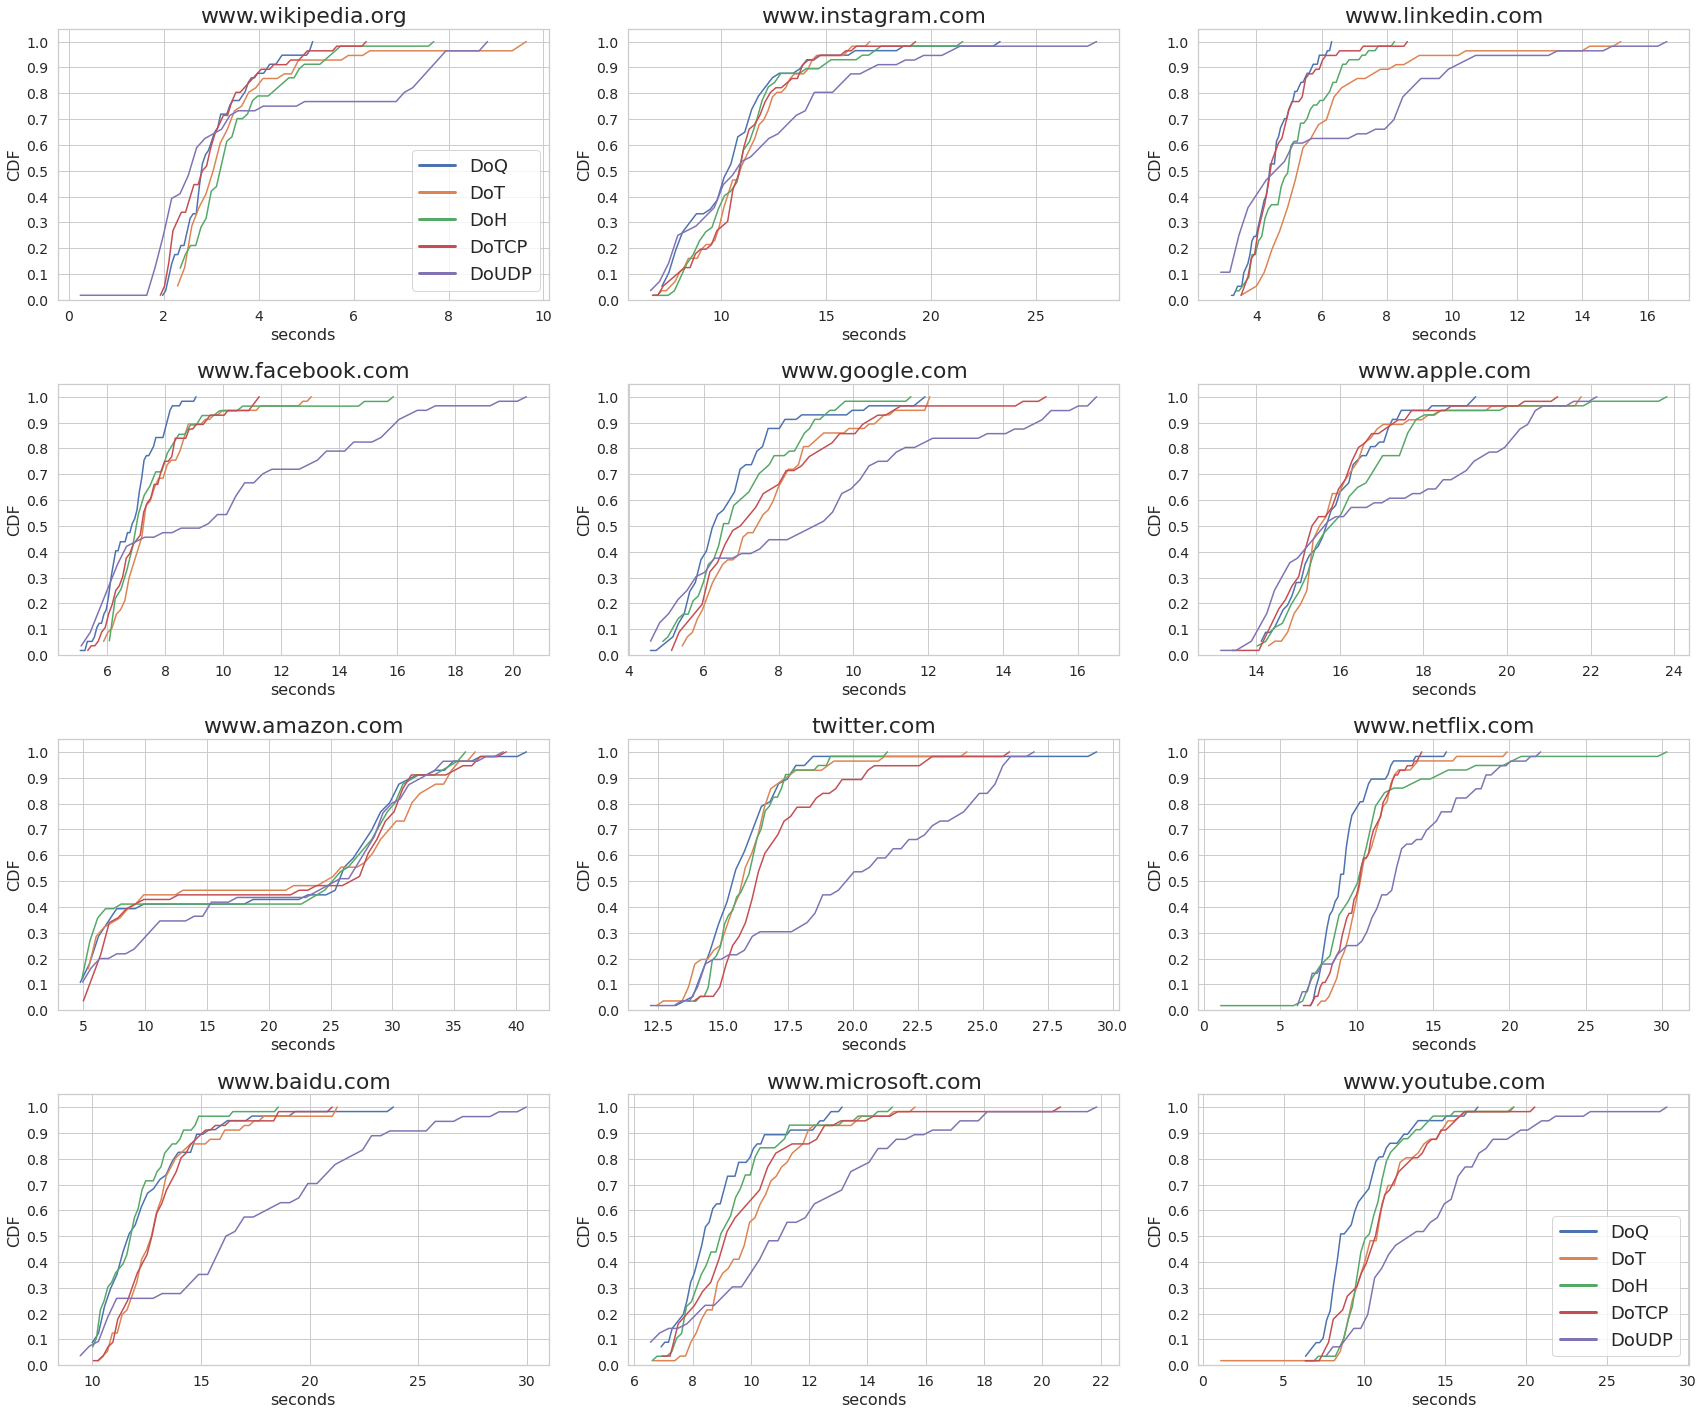

In [60]:
i = 0
fig, axs = plt.subplots(4, 3, figsize=(24, 20), sharey='col')
axes = []
times = {}

for domain in domain_order:
    dom_df = df[df['domain'] == domain]
    #dom_df = dom_df[dom_df['firstContentfulPaint'] > 0]
    for protocol in protocols:
        times[protocol] = dom_df[dom_df['protocol'] == protocol]['loadEventStart']
    ax = axs[int(i/3),i%3]
    sns.lineplot(x=calculateCDF(times['QUIC'])[0]/1000, y=calculateCDF(times['QUIC'])[1], label="DoQ", ax=ax)
    sns.lineplot(x=calculateCDF(times['TLS'])[0]/1000, y=calculateCDF(times['TLS'])[1], label="DoT", ax=ax)
    sns.lineplot(x=calculateCDF(times['HTTPS'])[0]/1000, y=calculateCDF(times['HTTPS'])[1], label="DoH", ax=ax)
    sns.lineplot(x=calculateCDF(times['TCP'])[0]/1000, y=calculateCDF(times['TCP'])[1], label="DoTCP", ax=ax)
    #sns.lineplot(x=[0], y=[0], label="DoTCP", ax=ax)
    sns.lineplot(x=calculateCDF(times['UDP'])[0]/1000, y=calculateCDF(times['UDP'])[1], label="DoUDP", ax=ax)

    ax.set_xlabel("seconds", fontsize = 16)
    ax.set_ylabel("CDF", fontsize = 16)
    ax.tick_params(labelleft=True)
    ax.tick_params(labelbottom=True)
    ax.set_title(domain, fontsize = 22)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylim(0.0, 1.05)
    ax.yaxis.set_ticks(np.arange(0.0, 1.01, 0.1))

    if i == 11 or i == 0:
        leg = ax.legend(loc="lower right", fontsize='medium')
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()
    ax.grid(True)
    fig.tight_layout()

    i += 1
plt.savefig("figures/bad-network-cdf.pdf", bbox_inches='tight')
plt.show()

In [119]:
times_dict = {}
for domain in domain_order:
    dom_df = df[df['domain'] == domain]
    times_dict[domain] = {}
    #dom_df = dom_df[dom_df['firstContentfulPaint'] > 0]
    #print(f"\n{domain}\n")
    protocols_noudp = protocols = ['QUIC', 'TLS', 'HTTPS', 'TCP']
    for protocol in protocols_noudp:
        times_dict[domain][protocol] = dom_df[dom_df['protocol'] == protocol]['loadEventStart']
        #print(f"{protocol} - {times_dict[domain][protocol].mean()}")
    times_dict[domain]['DoQ'] = times_dict[domain].pop('QUIC')
    times_dict[domain]['DoT'] = times_dict[domain].pop('TLS')
    times_dict[domain]['DoH'] = times_dict[domain].pop('HTTPS')
    times_dict[domain]['DoTCP'] = times_dict[domain].pop('TCP')
plt.rcParams["figure.figsize"] = (10,10)
heatmap_data = print_cdf_values_2(times_dict, 0.75)/1000
df_styled = heatmap_data.style.format(precision=2).background_gradient(cmap='RdYlGn_r', axis=1)
#dfi.export(df_styled,"figures/df_q3.png")
df_styled

,DoQ,DoT,DoH,DoTCP
www.wikipedia.org,3.39,3.64,3.87,3.43
www.instagram.com,11.46,12.24,11.96,12.10
www.linkedin.com,5.06,6.38,5.75,4.99
www.facebook.com,7.27,8.21,8.07,7.98
www.google.com,7.12,8.53,7.74,8.61
www.apple.com,16.42,16.43,17.02,16.29
www.amazon.com,29.06,30.32,29.59,30.14
twitter.com,16.49,16.60,16.63,17.61
www.netflix.com,9.70,11.49,11.24,11.58
www.baidu.com,13.38,13.62,12.98,13.86


****

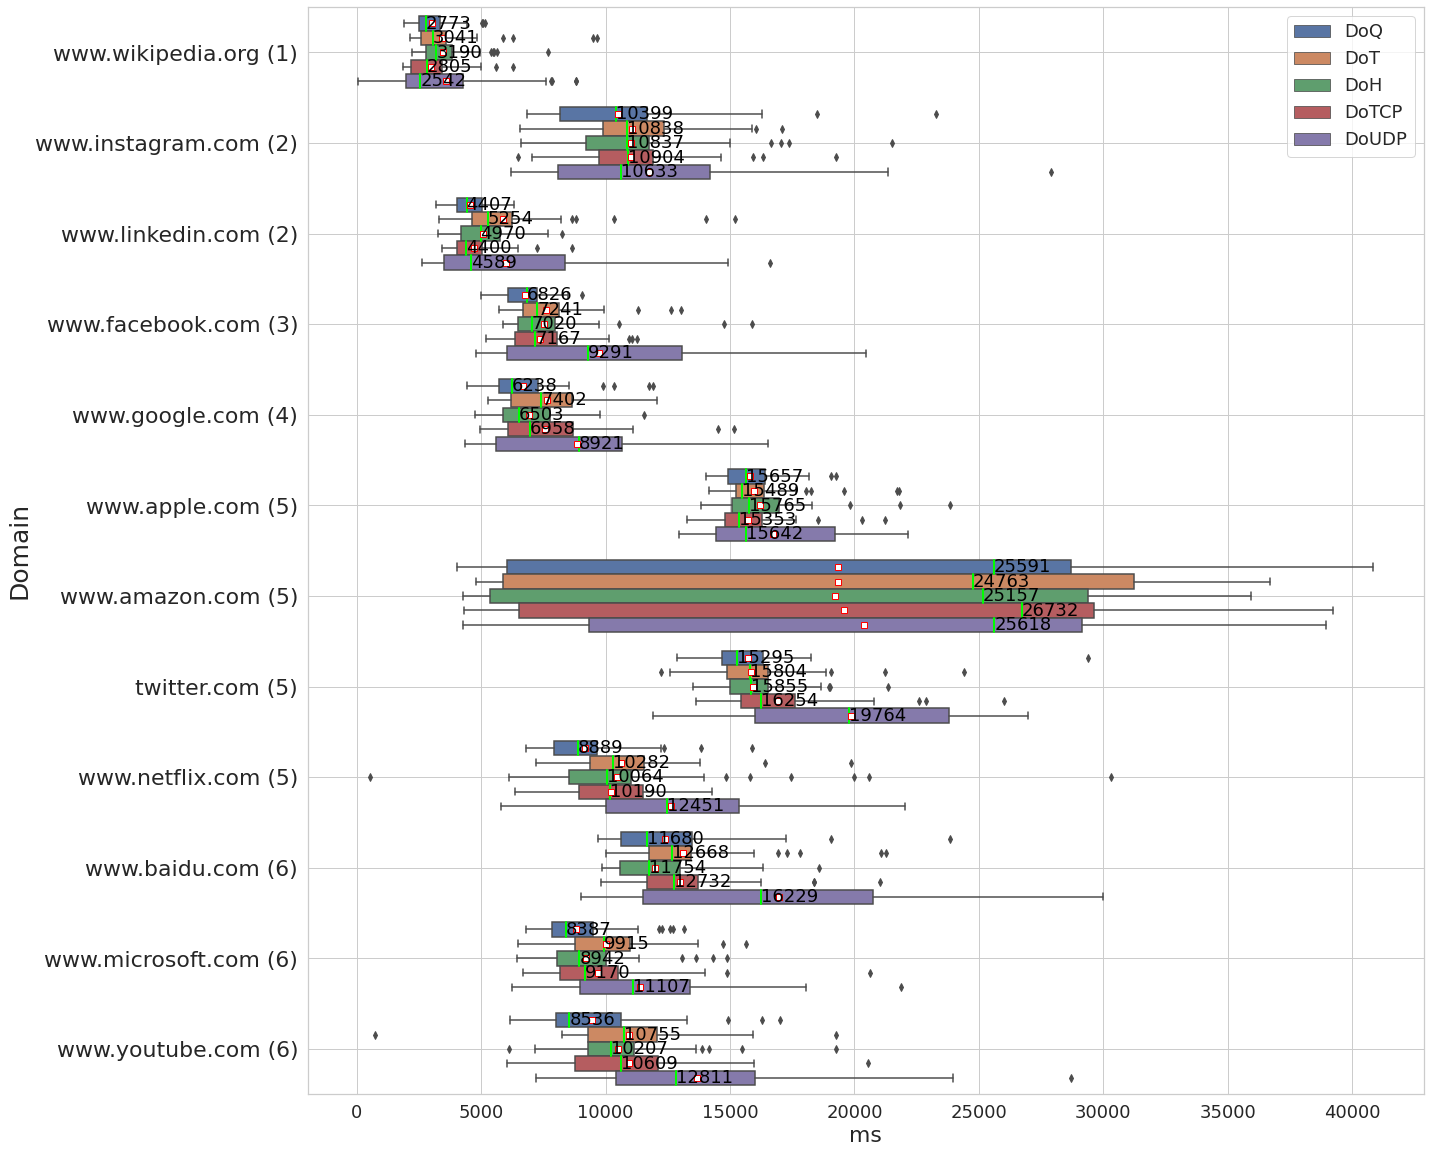

In [82]:
plt.rcParams["figure.figsize"] = (20,20)
multiCompare('vantagePoint', '', 'domain', ['loadEventStart'], ylabel='Domain', medians=True, showfliers=True)